In [1]:
# Add the path to the Utils folder
import sys
sys.path.append('../Utils')

from notebookUtils import visualize_class_distribution

# Preparation & Preprocessing
Download the dataset from https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip and unzip.
Create a new folder "laco.ai" in the project directory. 
Then copy the two folders "images" and "masks" to this folder.

Then go to the "Utils" folder and use the "prepareInputData.py" by *python3 prepareInputData.py*

If you use the same folder name as mentioned, you don't need to change anything in this script otherwise you need to change one variable.

main_folder = './../laco.ai'


In [ ]:
main_folder = './../laco.ai'

# Data Exploration
After the preparation and preprocessing there are three folders in the Data directory: train, validate, and test.
The train folder contains 8388 image patches. Each satellite image in the sat folder has one equivalent in the  gt folder. Each image patch has a size of 512x512 pixels.
The validate folder contains 990 image patches and the test folder contains 1296 images.

Now we can look at the data. Let's visualize one examples from the train dataset. You see on the left an satellite image with the corresponding ground truth (GT) image. The GT image on the right is an segemented version of the image on the left where each pixel from the image on the left has a class label on the right. There are 5 possible classes:

- 0: 'unlabeled',
- 1: 'buildings',
- 2: 'woodlands',
- 3: 'water',
- 4: 'road'

/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


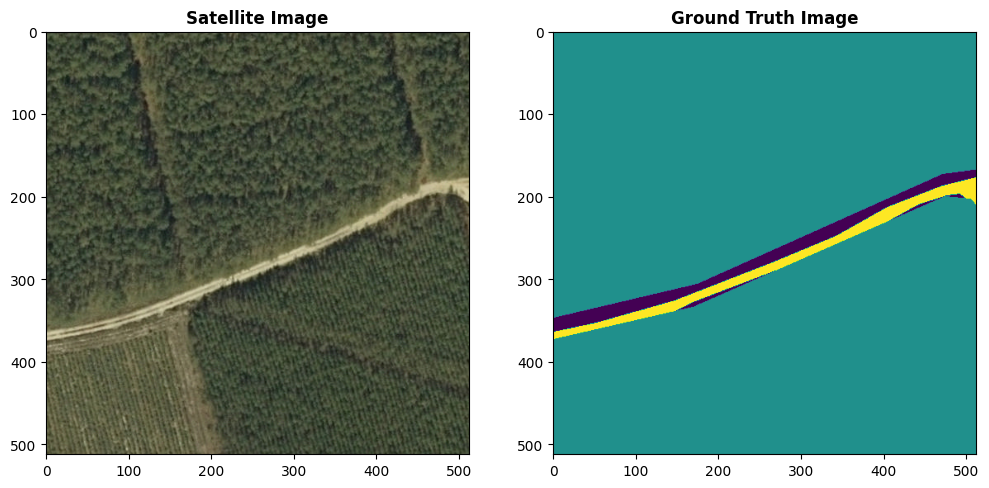

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

tif_file = './../Data/train/sat/sat_M-33-7-A-d-2-3_01_02.tif'
mask_file = './../Data/train/gt/gt_M-33-7-A-d-2-3_01_02.tif'

tif_dataset = rasterio.open(tif_file)
mask_dataset = rasterio.open(mask_file)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

show(tif_dataset, ax=axes[0], title='Satellite Image')
show(mask_dataset, ax=axes[1], title='Ground Truth Image')
plt.show()

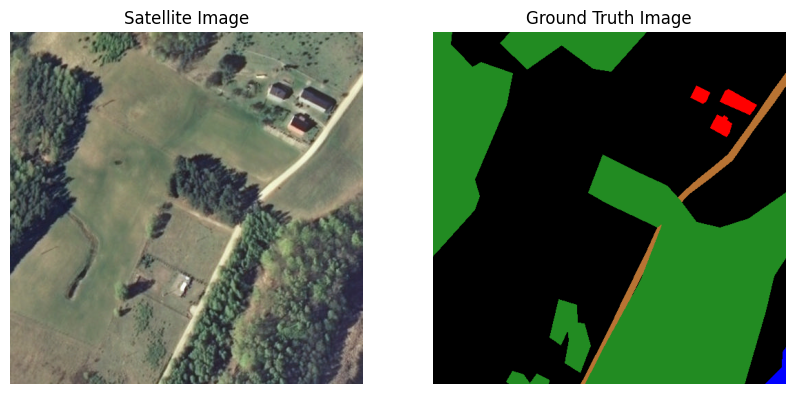

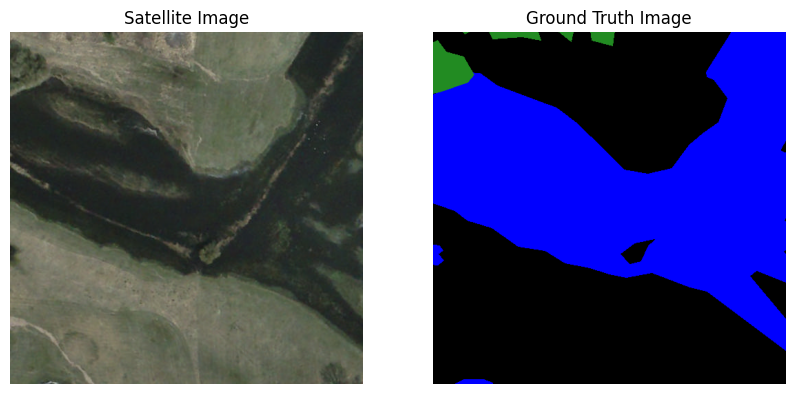

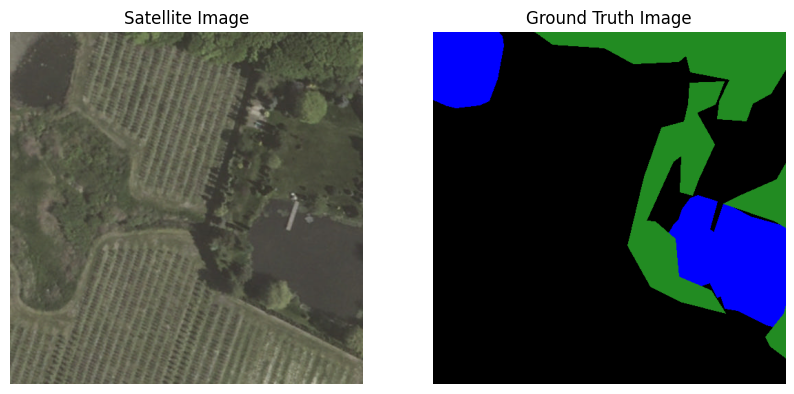

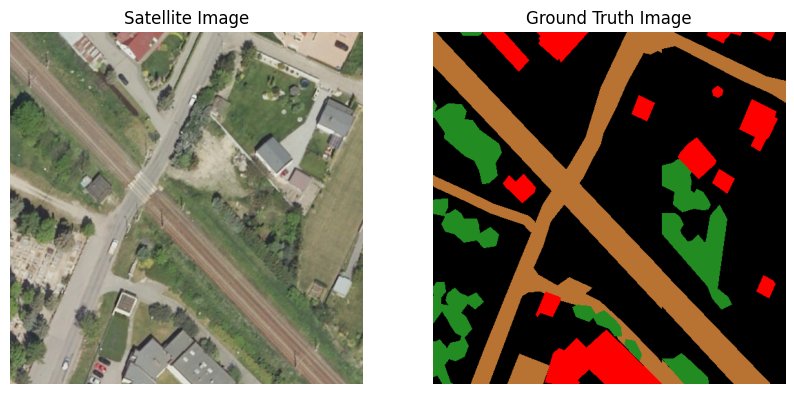

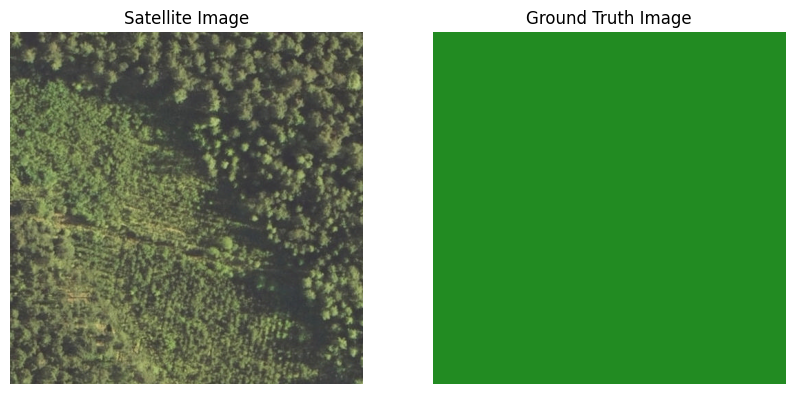

In [4]:
from notebookUtils import visualize_image_pairs
# Example usage
satellite_folder = './../Data/train/sat/'
ground_truth_folder = './../Data/train/gt/'
visualize_image_pairs(satellite_folder, ground_truth_folder, num_samples=5)

Processing files: 100%|██████████| 8388/8388 [06:06<00:00, 22.88file/s]


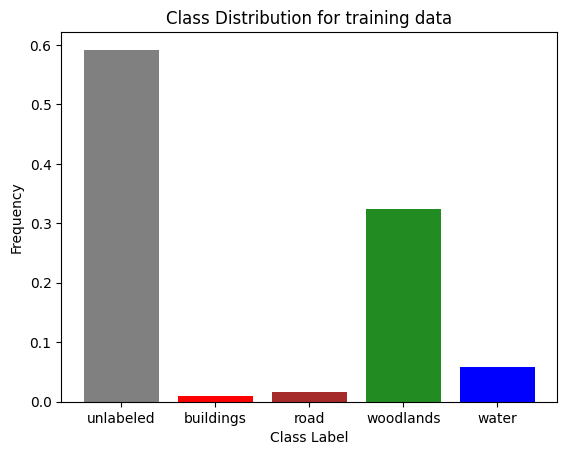

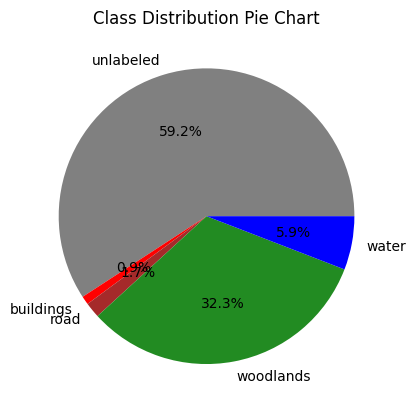

Class Distribution Summary:
unlabeled: 1301309976 samples, 59.18%
buildings: 20448818 samples, 0.93%
road: 37195495 samples, 1.69%
woodlands: 711061784 samples, 32.34%
water: 128847799 samples, 5.86%


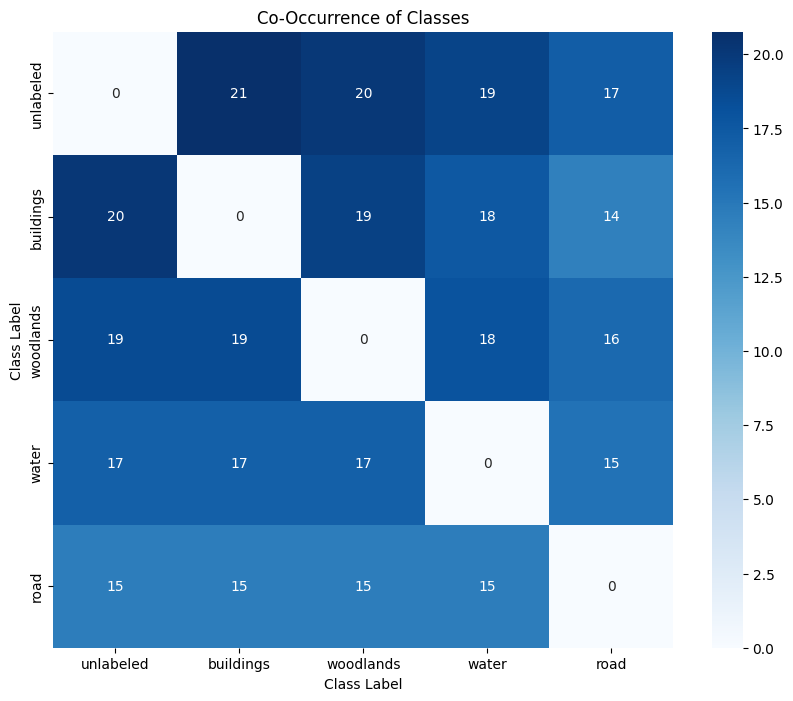

In [5]:
# Define the path to the training ground truth folder
gt_folder = './../Data/train/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for training data')

Processing files:   0%|          | 0/990 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 990/990 [00:40<00:00, 24.32file/s]


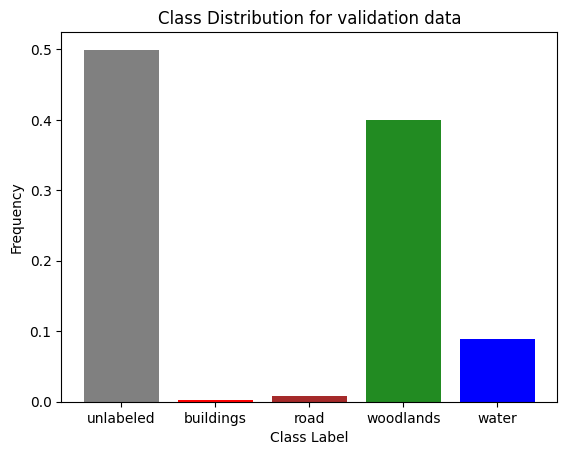

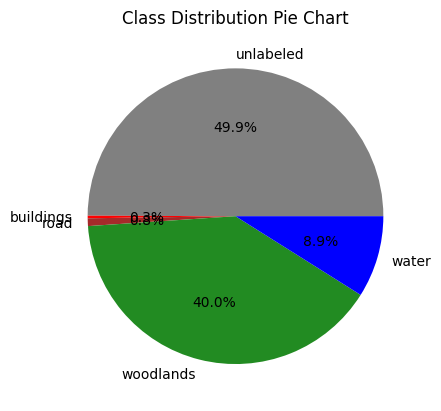

Class Distribution Summary:
unlabeled: 129628988 samples, 49.95%
buildings: 715881 samples, 0.28%
road: 2190542 samples, 0.84%
woodlands: 103796083 samples, 40.00%
water: 23191066 samples, 8.94%


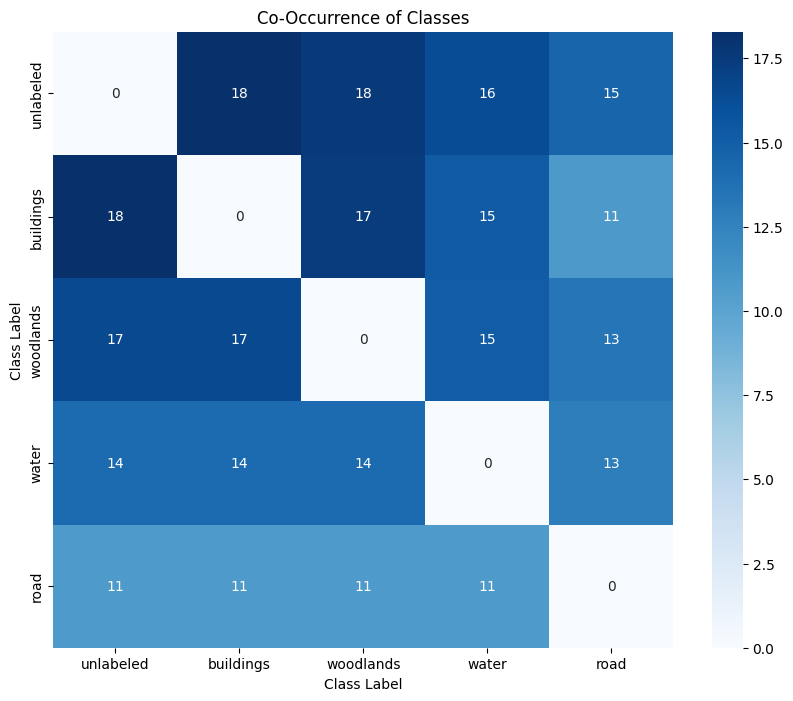

In [6]:
# Define the path to the training ground truth folder
gt_folder = './../Data/validate/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for validation data')

Processing files:   0%|          | 0/1296 [00:00<?, ?file/s]/home/erni/Schreibtisch/ML_Zoomcamp_2023_Capstone2_Project/.venv/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Processing files: 100%|██████████| 1296/1296 [00:57<00:00, 22.41file/s]


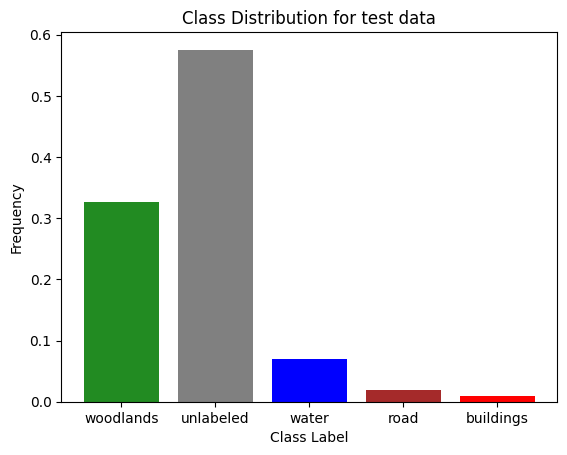

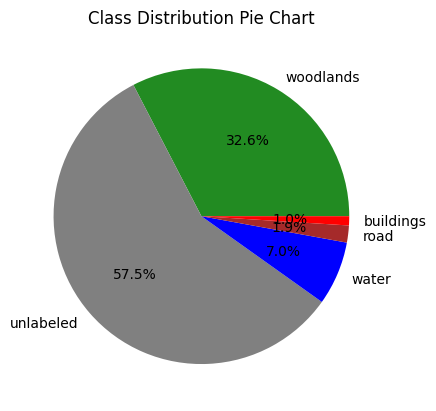

Class Distribution Summary:
woodlands: 110786661 samples, 32.61%
unlabeled: 195496667 samples, 57.54%
water: 23730250 samples, 6.98%
road: 6322836 samples, 1.86%
buildings: 3402210 samples, 1.00%


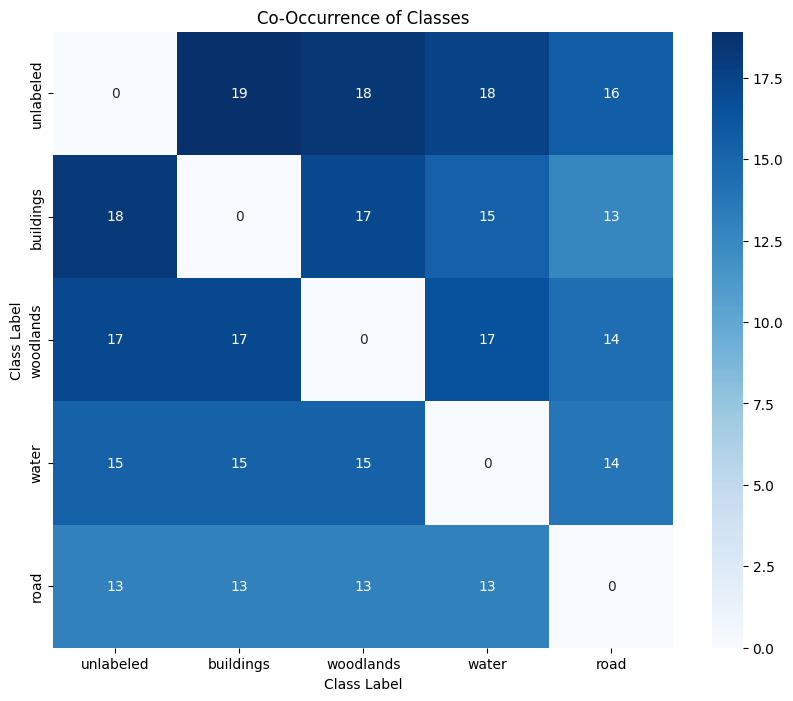

In [7]:
# Define the path to the training ground truth folder
gt_folder = './../Data/test/gt/'
# Visualize the class distribution from a random subset of ground truth files
visualize_class_distribution(gt_folder, num_samples=9000, title='Class Distribution for test data')

# Model Architecture

In [ ]:
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from PIL import Image

# Define constants
num_classes = 5
train_sat_folder = "./../Data/train/sat/"
train_gt_folder = "./../Data/train/gt/"

val_sat_folder = "./../Data/validate/sat/"
val_gt_folder = "./../Data/validate/gt/"

# Function to load and preprocess the dataset
def load_data(sat_folder, gt_folder):
    input_images = []
    output_masks = []

    for filename in tqdm(os.listdir(sat_folder)):
        if filename.endswith(".tif"):
            input_path = os.path.join(sat_folder, filename)
            output_path = os.path.join(gt_folder, filename.replace("sat_", "gt_"))

            # Load and preprocess input image
            input_image = np.array(Image.open(input_path)) / 255.0  # Normalize to [0, 1]
            input_images.append(input_image)

            # Load and preprocess output mask
            output_mask = np.array(Image.open(output_path))
            output_mask = keras.utils.to_categorical(output_mask, num_classes=num_classes)
            output_masks.append(output_mask)

    return np.array(input_images), np.array(output_masks)

# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder)

# Define U-Net model for 5 classes
def unet_model(input_size=(512, 512, 3), num_classes=5):
    inputs = keras.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    up1 = layers.UpSampling2D((2, 2))(conv2)

    # Output layer with softmax activation for multi-class classification
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(up1)

    model = keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
model = unet_model(num_classes=num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Save the trained model
model.save("unet_model_multiclass.h5")


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from PIL import Image

tf.config.set_visible_devices([], 'GPU')

# Define constants
num_classes = 5
input_size = (512, 512, 3)
batch_size = 1  # You can adjust this based on your available memory
epochs = 10
train_sat_folder = "./../Data/train/sat/"
train_gt_folder = "./../Data/train/gt/"

val_sat_folder = "./../Data/validate/sat/"
val_gt_folder = "./../Data/validate/gt/"

# Function to load and preprocess the dataset
def load_data(sat_folder, gt_folder, batch_size=batch_size):
    input_images = []
    output_masks = []

    filenames = [filename for filename in os.listdir(sat_folder) if filename.endswith(".tif")]
    num_batches = len(filenames) // batch_size

    for batch_idx in tqdm(range(num_batches), desc="Loading batches", unit="batch"):
        batch_filenames = filenames[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        
        batch_inputs = []
        batch_outputs = []
        for filename in batch_filenames:
            input_path = os.path.join(sat_folder, filename)
            output_path = os.path.join(gt_folder, filename.replace("sat_", "gt_"))

            # Load and preprocess input image
            input_image = np.array(Image.open(input_path)) / 255.0  # Normalize to [0, 1]
            batch_inputs.append(input_image)

            # Load and preprocess output mask
            output_mask = np.array(Image.open(output_path))
            output_mask = keras.utils.to_categorical(output_mask, num_classes=num_classes)
            batch_outputs.append(output_mask)

        input_images.append(np.array(batch_inputs))
        output_masks.append(np.array(batch_outputs))

    return np.vstack(input_images), np.vstack(output_masks)

# Load and preprocess the training dataset
X_train, y_train = load_data(train_sat_folder, train_gt_folder)

# Load and preprocess the validation dataset
X_val, y_val = load_data(val_sat_folder, val_gt_folder)

# Define U-Net model for 5 classes
def unet_model(input_size=(512, 512, 3), num_classes=5):
    inputs = keras.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    conv1 = layers.Conv2D(64, 3, activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    # Decoder
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(128, 3, activation="relu", padding="same")(conv2)
    up1 = layers.UpSampling2D((2, 2))(conv2)

    # Output layer with softmax activation for multi-class classification
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(up1)

    model = keras.Model(inputs, outputs)
    return model

# Initialize and compile the model
model = unet_model(num_classes=num_classes)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model with batch processing
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Save the trained model
model.save("unet_model_multiclass_batch.h5")


2024-01-07 22:32:24.357624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 22:32:24.357675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 22:32:24.412892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 22:32:24.528071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 22:32:25.570952: W tensorflow/compiler/tf2

KeyboardInterrupt: 